In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from motion_integration import (integrate_motion, evaluate_motion_equations, 
                                nondimensionalize, get_bond_lengths, 
                                find_bond_forces, repulsive_force)
from continue_int import continue_integration
from binding_expt import parse_file
from timeit import default_timer as timer

In [2]:
with np.load('data/bd_run070.npz') as data:
    t_dat = data['t']
    x_dat, y_dat, z_dat = data['x'], data['y'], data['z']
    rmat_dat = data['r_matrices']
    receptors = data['receptors']
    ba_dat = data['bond_array']

In [3]:
pars = parse_file('bd_run070')
a, b = pars['a'], pars['b']
n_nodes = pars['n_nodes']
adaptive = pars['adaptive']
domain = 'wall'
proc = 1
del pars['filename']
del pars['seed']
del pars['t_start']
del pars['t_end']
del pars['num_steps']
del pars['n_nodes']
del pars['a']
del pars['b']
del pars['adaptive']
del pars['one_side']
del pars['check_bonds']
t_sc, f_sc, lam, k0_on, k0_off, eta, eta_ts, kappa = nondimensionalize(l_scale=1, mu=4e-3, temp=310., **pars)

In [4]:
def find_forces(i):
    rmat = rmat_dat[..., i]
    true_receptors = np.dot(receptors, rmat.T)
    x1, x2, x3 = x_dat[i], y_dat[i], z_dat[i]
    true_receptors += np.array([[x1, x2, x3]])

    bond_list = [row for row in ba_dat[..., i] if row[0] > -1]
    get_bond_lengths(bond_list, true_receptors)

    center = np.array([x1, x2, x3])
    return find_bond_forces(receptors, bond_list, center, rmat, kappa, lam)

In [5]:
i_start = np.nonzero(t_dat > .139999)[0][0]

In [6]:
forces, torques = find_forces(i_start)

In [7]:
bonds = ba_dat[..., i_start]

In [8]:
def exact_vels(em):
    return np.zeros(6)

In [9]:
a, b = 1.5, 0.5

In [10]:
def fun(t, y):
    center = y[:3]
    rmat = y[3:].reshape((3, 3))
    forces, torques = find_bond_forces(receptors, bonds, center, rmat, kappa, lam, one_side=True)
    point, rep_force = repulsive_force(center[0], rmat[:, 0])
    forces += np.array([rep_force, 0, 0])
    torques += np.cross([point[0] - center[0], point[1], point[2]],
                        [rep_force, 0, 0])
    result = evaluate_motion_equations(
        center[0], rmat[:, 0], forces, torques, exact_vels, a=a, b=b, n_nodes=n_nodes, 
        domain=domain, proc=proc)
    drmat = np.cross(result[3:6], rmat, axisb=0, axisc=0)
    dy = np.concatenate((result[:3], drmat.reshape((9,))))
    return dy

In [11]:
center0 = np.array([x_dat[i_start], y_dat[i_start], z_dat[i_start]])
y0 = np.concatenate((center0, rmat_dat[..., i_start].reshape((9,))))

In [12]:
t_dat[i_start:i_start+30]

array([0.14      , 0.14025   , 0.14028125, 0.1403125 , 0.140375  ,
       0.1405    , 0.1405625 , 0.14059375, 0.140625  , 0.14075   ,
       0.1408125 , 0.14084375, 0.140875  , 0.141     , 0.1410625 ,
       0.14109375, 0.141125  , 0.14125   , 0.1413125 , 0.14134375,
       0.141375  , 0.1415    , 0.1415625 , 0.14159375, 0.141625  ,
       0.14175   , 0.1418125 , 0.14184375, 0.141875  , 0.142     ])

In [13]:
t_span = (t_dat[i_start], 0.154)
print(t_span)

(0.13999999999999982, 0.154)


In [14]:
evaluate_motion_equations.counter = 0
start1 = timer()
sol = solve_ivp(fun, t_span, y0, method='Radau', dense_output=True, t_eval=np.linspace(0.142, 0.154, 7))
end1 = timer()

Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.12

In [15]:
evaluate_motion_equations.counter

21

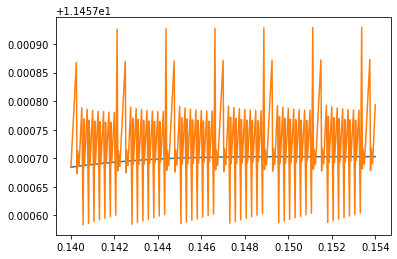

In [16]:
plt.plot(t_dat[i_start:i_start+210], sol.sol(t_dat[i_start:i_start+210])[2])
plt.plot(t_dat[i_start:i_start+210], z_dat[i_start:i_start+210])

Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.12

Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8
Assembling quadrature matrix for eps = 0.1261902586321847, nodes = 8
Solving for forces for eps = 0.1261902586321847, nodes = 8
Finished eps=0.1261902586321847, n_nodes=8


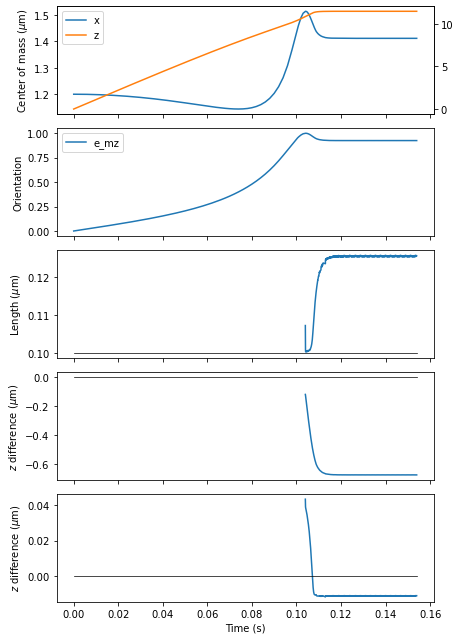

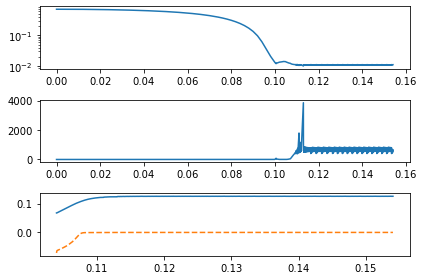

In [17]:
evaluate_motion_equations.counter = 0
start2 = timer()
continue_integration('bd_run070', 0.154, i_start)
end2 = timer()

In [18]:
print(evaluate_motion_equations.counter)
print(end1 - start1)
print(end2 - start2)

822
4.898579206999999
198.127735087
